# Dataset and libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import emoji
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Flatten , Dropout , MaxPooling1D , Input , Dense, Embedding , Conv1D , Concatenate , Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Activation
from textblob import TextBlob
stop_words = set(stopwords.words('english'))
pd.set_option('display.max_columns', 500)


In [2]:
news_articles = pd.read_json("news-category-dataset/News_Category_Dataset_v2.json", lines = True)

# Functions

In [3]:
def extract_emojis(str):
    '''Return text without emojis'''
    return ''.join(c for c in str if c not in emoji.UNICODE_EMOJI)
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    '''Return text without tags'''
    return TAG_RE.sub('', text)
def preprocess_text(sen):
    '''Return text without tags,punctuations, numbers, Single character,multiple spaces and emoji'''  
    sentence = remove_tags(sen)
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    sentence = extract_emojis(sentence)
    string=""
    for word in sentence.split():
        word = ("".join(e for e in word if e.isalnum()))
        word = word.lower()
        if not word in stop_words:
            string += word + " " 
    return string
def counter(sentence):
    '''Return the number of words in sentence. Input: str Output: num of words'''
    return len(sentence.split())

def test_sentiment_polarity(text):
    '''Return the number of polarity [-1,1] with -1 negative and 1 positive Input: str Output: float'''
    data = TextBlob(text)
    return data.sentiment.polarity#, data.sentiment.subjectivity
def test_sentiment_subjectivity(text):
    '''Return the number of subjetivity [0,1] with 0 very objective and 1 very subobjective Input: str Output: float'''
    data = TextBlob(text)
    return  data.sentiment.subjectivity
def evaluate_model(n_history , model , x_train , y_train):
    '''Generate plot of 'Training and validation accuracy' and  'Training and validation loss' and model.evaluate, model, x_train, y_trainInputs: outputs model.fit Output: float'''

    acc = n_history.history['accuracy']
    val_acc = n_history.history['val_accuracy']
    loss = n_history.history['loss']
    val_loss = n_history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.title('Training and validation accuracy')
    plt.plot(epochs, acc, 'red', label='Training acc')
    plt.plot(epochs, val_acc, 'blue', label='Validation acc')
    plt.legend()
    plt.figure()
    plt.title('Training and validation loss')
    plt.plot(epochs, loss, 'red', label='Training loss')
    plt.plot(epochs, val_loss, 'blue', label='Validation loss')
    plt.legend()
    plt.show()
    score = model.evaluate(x_train, y_train, verbose=1)
    print("Test Score:", score[0])
    print("Test Accuracy:", score[1])



In [4]:
#Remove duplicate o Data with same headline
news_articles.sort_values('headline', inplace=True , ascending=False)
duplicated_articles_series = news_articles.duplicated('headline', keep = False)
news_articles = news_articles[~duplicated_articles_series]
print("Total number of articles after removing duplicates:", news_articles.shape[0])

Total number of articles after removing duplicates: 198627


In [5]:
#Transform Data set.
news_articles["all_text"]=news_articles["short_description"] + " "+news_articles["headline"]#merge short_description and headline
news_articles["all_text_clean"]=news_articles["all_text"].apply(preprocess_text)
news_articles["all_text_count"]=news_articles["all_text_clean"].apply(counter)
news_articles["all_text_init"]=news_articles["all_text"].apply(counter)
#Prepare Y data
Y = news_articles["category"]
news_articles["counter"]=np.ones(news_articles.shape[0])
values = array(Y)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
news_articles["integer_encoded"]=integer_encoded
#Prepare X data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(news_articles.all_text_clean)
X = tokenizer.texts_to_sequences(news_articles.all_text_clean)
news_articles['words'] = X

In [6]:
#Remove text very small with 4 charapters or less or short_description or with less of 4
news_articles=news_articles[ ((news_articles['all_text_count'] >= 5) & (news_articles["short_description"].str.len()>= 5) & (news_articles["headline"].str.len()>= 5)) ]
print("Total number of articles after filter:", news_articles.shape[0])

Total number of articles after filter: 178607


In [7]:
#num_classes=news_articles["category"].nunique()+1

In [8]:
maxlen=max(news_articles["all_text_count"])#Max length of sentences
X = np.array(list(pad_sequences(news_articles.words, maxlen=maxlen)))
Y = to_categorical(list(news_articles["integer_encoded"]))
#Define Data of train and test, with 10% in test
x_test , x_train,  y_test , y_train = train_test_split( X , Y , test_size=int(.1*len(news_articles)) , random_state=42, stratify=news_articles.category)

In [9]:
#Verificate Dimentions
print(x_train.shape , x_test.shape , y_train.shape , y_test.shape)

(17860, 133) (160747, 133) (17860, 41) (160747, 41)


In [10]:
NumClasses =news_articles["integer_encoded"].nunique()

# Classification Model

In [11]:
word_index = tokenizer.word_index

EMBEDDING_DIM = 100

inp = Input(shape=(maxlen,) , dtype='int32')

embedding_layer = Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            input_length=maxlen,
                            trainable=True)
embedding = embedding_layer(inp)
stacks = []
for kernel_size in [3 , 9 , 12]:
    conv = Conv1D(120, kernel_size, padding='same', activation='relu', strides=1)(embedding)#Convolution in data
    pool = MaxPooling1D(pool_size=3)(conv)#Max pooling operation transform data length in X/3 data
    drop = Dropout(0.2)(pool)#20 % change to 0
    stacks.append(drop)

merged = Concatenate()(stacks)#Join the output
flatten = Flatten()(merged)#Trasformde plane data
drop = Dropout(0.2)(flatten)#20 % change to 0
outp = Dense(NumClasses, activation='softmax')(drop)#Output

modelCNN = Model(inputs=inp, outputs=outp)
modelCNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

modelCNN.summary()
textcnn_history = modelCNN.fit(x_train, 
                              y_train, 
                              batch_size=128, 
                              epochs=10, 
                              validation_data=(x_test, y_test))

 


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 133)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 133, 100)     8401200     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 133, 120)     36120       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 133, 120)     108120      embedding[0][0]                  
______________________________________________________________________________________________

In [12]:
# Save to model json
model_json = modelCNN.to_json()
with open("modelCNN.json", "w") as json_file:
    json_file.write(model_json)
# save weights
modelCNN.save_weights("modelCNN.h5")
print("Modelo Guardado!")

Modelo Guardado!


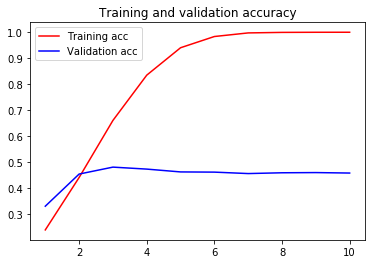

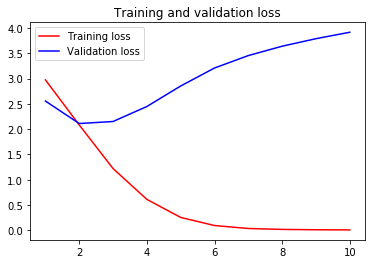

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Test Score: 3.9166037753679803
Test Accuracy: 0.45890749


In [13]:
evaluate_model(textcnn_history,modelCNN,x_test, y_test)

# Evaluate writing styles

In [14]:
news_articles["polarity"]=news_articles["all_text"].apply(test_sentiment_polarity)
news_articles["subjectivity"]=news_articles["all_text"].apply(test_sentiment_subjectivity)

In [15]:
news_styles=news_articles[["category","polarity","subjectivity"]]

[Text(0, 0, 'WOMEN'),
 Text(0, 0, 'HEALTHY LIVING'),
 Text(0, 0, 'BUSINESS'),
 Text(0, 0, 'DIVORCE'),
 Text(0, 0, 'QUEER VOICES'),
 Text(0, 0, 'WEIRD NEWS'),
 Text(0, 0, 'BLACK VOICES'),
 Text(0, 0, 'WORLD NEWS'),
 Text(0, 0, 'POLITICS'),
 Text(0, 0, 'ENTERTAINMENT'),
 Text(0, 0, 'COMEDY'),
 Text(0, 0, 'IMPACT'),
 Text(0, 0, 'THE WORLDPOST'),
 Text(0, 0, 'GREEN'),
 Text(0, 0, 'PARENTING'),
 Text(0, 0, 'GOOD NEWS'),
 Text(0, 0, 'LATINO VOICES'),
 Text(0, 0, 'MONEY'),
 Text(0, 0, 'ARTS & CULTURE'),
 Text(0, 0, 'MEDIA'),
 Text(0, 0, 'WEDDINGS'),
 Text(0, 0, 'CULTURE & ARTS'),
 Text(0, 0, 'CRIME'),
 Text(0, 0, 'HOME & LIVING'),
 Text(0, 0, 'FOOD & DRINK'),
 Text(0, 0, 'TASTE'),
 Text(0, 0, 'ENVIRONMENT'),
 Text(0, 0, 'COLLEGE'),
 Text(0, 0, 'TRAVEL'),
 Text(0, 0, 'PARENTS'),
 Text(0, 0, 'WELLNESS'),
 Text(0, 0, 'TECH'),
 Text(0, 0, 'STYLE & BEAUTY'),
 Text(0, 0, 'FIFTY'),
 Text(0, 0, 'SCIENCE'),
 Text(0, 0, 'SPORTS'),
 Text(0, 0, 'EDUCATION'),
 Text(0, 0, 'STYLE'),
 Text(0, 0, 'ARTS'),
 Te

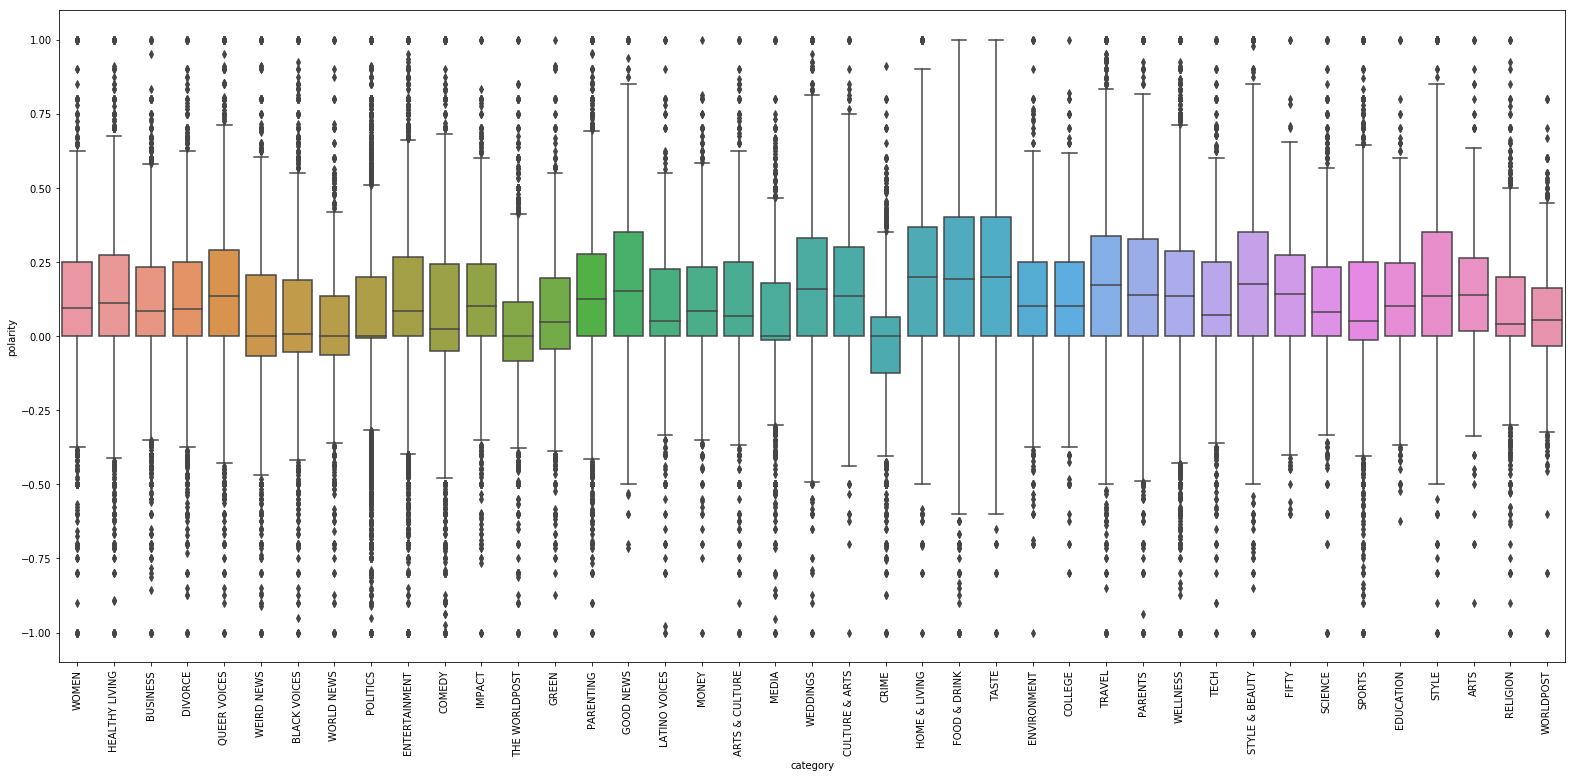

In [16]:
import matplotlib.pyplot as pp
pp.figure(figsize=(27, 12))
chart =sns.boxplot(x="category", y="polarity", data=news_styles)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

[Text(0, 0, 'WOMEN'),
 Text(0, 0, 'HEALTHY LIVING'),
 Text(0, 0, 'BUSINESS'),
 Text(0, 0, 'DIVORCE'),
 Text(0, 0, 'QUEER VOICES'),
 Text(0, 0, 'WEIRD NEWS'),
 Text(0, 0, 'BLACK VOICES'),
 Text(0, 0, 'WORLD NEWS'),
 Text(0, 0, 'POLITICS'),
 Text(0, 0, 'ENTERTAINMENT'),
 Text(0, 0, 'COMEDY'),
 Text(0, 0, 'IMPACT'),
 Text(0, 0, 'THE WORLDPOST'),
 Text(0, 0, 'GREEN'),
 Text(0, 0, 'PARENTING'),
 Text(0, 0, 'GOOD NEWS'),
 Text(0, 0, 'LATINO VOICES'),
 Text(0, 0, 'MONEY'),
 Text(0, 0, 'ARTS & CULTURE'),
 Text(0, 0, 'MEDIA'),
 Text(0, 0, 'WEDDINGS'),
 Text(0, 0, 'CULTURE & ARTS'),
 Text(0, 0, 'CRIME'),
 Text(0, 0, 'HOME & LIVING'),
 Text(0, 0, 'FOOD & DRINK'),
 Text(0, 0, 'TASTE'),
 Text(0, 0, 'ENVIRONMENT'),
 Text(0, 0, 'COLLEGE'),
 Text(0, 0, 'TRAVEL'),
 Text(0, 0, 'PARENTS'),
 Text(0, 0, 'WELLNESS'),
 Text(0, 0, 'TECH'),
 Text(0, 0, 'STYLE & BEAUTY'),
 Text(0, 0, 'FIFTY'),
 Text(0, 0, 'SCIENCE'),
 Text(0, 0, 'SPORTS'),
 Text(0, 0, 'EDUCATION'),
 Text(0, 0, 'STYLE'),
 Text(0, 0, 'ARTS'),
 Te

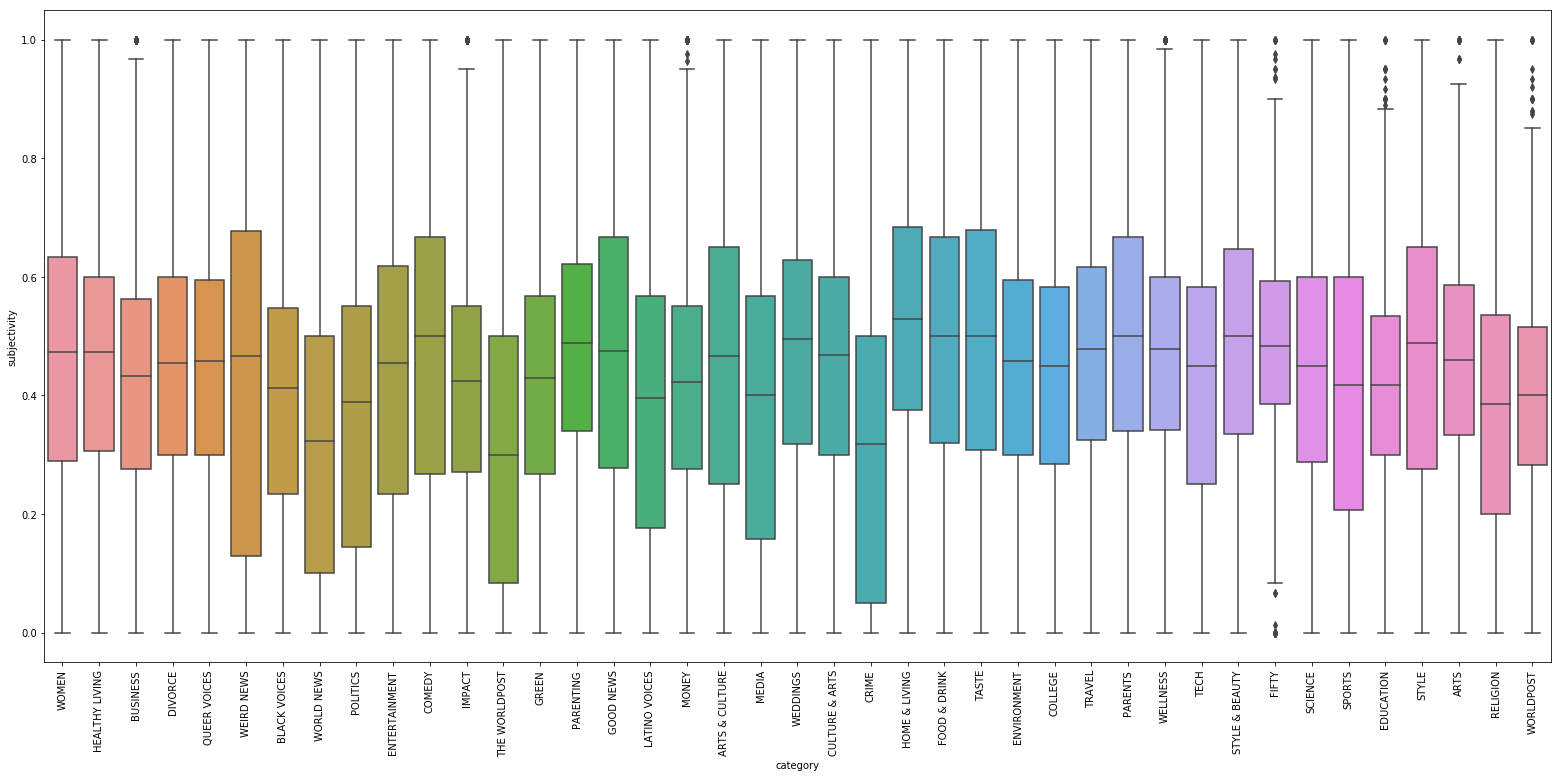

In [17]:
import matplotlib.pyplot as pp
pp.figure(figsize=(27, 12))
chart =sns.boxplot(x="category" , y="subjectivity" , data=news_styles)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

# Authors

In [18]:
news_articles_au=news_articles[ ( (news_articles['authors']!="") ) ]
authors=news_articles_au.pivot_table(index='authors', values= "counter" , aggfunc=[sum]).sort_values(("sum","counter") , ascending=[False])
index_ori=authors.index
temp=list(authors.index)
temp[2]="Reuters"
temp[6]="Andy Mcdonald"
authors.index=temp
authors.index.name='authors'

In [19]:
#Text garbage in author variable
nonauthor=['ph.d. ',"mosaic science","the atlantic","epicurious","huffpost italy","budget travel""offmetro.com","untapped cities","watch us run","georgia state university","the mid","md (radm","refugees deeply","intent.com","u.s. news","watch us run","georgia state university","prevention","the worldpost","the worldpost","away.com","health","mindful","founder","imbibe","lauren ","national geographic","the american prospect",' ph.d.','burgerbusiness',"the huffington post",'founder ',"tomdispatch","associate professor","american heart association",'sierra',"writer",'editor-in-chief',"doctors without borders","cadcii","associated pres","senior writer","style","where",'outspeak',"iona",'eckhart tolle','cpt "jz"','lcsw-r','huffington post','lsw','dpt','m.s.ed','s.j.','r.ph.','acsw','f.a.c.c.','ph.d', 'm.d.', 'm.p.h.',"md","m.d. m.s.",'psyd',"psy.d.","m.phil.","f.c.c.p.","d.absm","abpp","iii","ph.d","psy.d.","m.ed","m.ed.","m.phil.ed.","ed.m. ","m.ed.","n.d.","faed","rn","lcsw-rd.o.","m.a.p.p.","m.b.a.","cdn","m.d","pti","cwhc","dnp","fnp-bc","faanp","columnist\neditor-at-large","huffpost","ccc-slp","licsw","lisw","d.v.m.","cfp","jr. ","msc","d.o.","ph. d.","fabm","columnist\ncolumnist","ces","mba phd","ph.d. abpp","psyd","cpc","ap","cpa","jr","cce","faan","cch","bsn","m.s.","lcsw-c","c.s.c.s.","l.d.","mph","p.c.","m.s.","clc","l.ac.","csat-s","f.a.c.s.","mpa","ceds","columnist","phd ","r.d.","jr.","nd","cns","rd","cde","mft","rdn","cssd","mbe","faap","lcsw","ms","ldn","r.n.","ob-gyn n.p.","ma","livescience.com","outsports","esq.","chfs","columnistcolumnist","d.d.s.","msw","csp","facp","rdn ","editorial partner","mba","phd.","ph.d.","m.a.","ed.d.","phd","j.d.","hhc","m.d.","m.p.h.","m.f.t.","cscs","live science","md"]
def split_author(text):
    """Split and clear names of authors Input str Output list author """
    text=text.lower()
    if text.find("contributor")>0:
        text=text.split("contributor")[0]
    if text.find("guest writer")>0:
        text=text.split("guest writer")[0]
    text=text.split(",")
    text2=[]
    for i in text:
        j=i.replace(" and ", " ")
        if j.startswith(" "):
            j=j[1:]
        if len(j)>5:
            if j not in set(nonauthor) :
                text2.append(j)
    return text2
Sal=[]
for i in index_ori:
    a=split_author(i)
    Sal=Sal+a



In [20]:
authorsDB=news_articles_au.pivot_table(index='authors' , values= "counter" , aggfunc=[sum]).sort_values(("sum" , "counter") ,ascending=[False])

In [21]:
autorsC=authorsDB.to_dict()
Tr={}
for i in set(Sal):
    for j,k in autorsC['sum' , 'counter'].items():
        if j.lower().find(i)>0 or i==j.lower(): #if Data of have i or name in j or Data i and j are equal 
            if i.title() not in Tr.keys():
                Tr[i.title()]=k
            else:
                Tr[i.title()]+=k

In [22]:
#DATA of author corriged and sum the data of articles shared
authorsC=sorted(Tr.items() , key = lambda kv:(kv[1] , kv[0]) ,reverse = True)
authorsC=pd.DataFrame.from_dict(authorsC)
print(sum(authorsC[:20][1]))
print(sum(authorsC[:][1]))
authorsC.columns=['authors', 'counterComp']
authorsC[:20]


22638.0
80119.0


,authors,counterComp
0,Reuters,3394.0
1,Lee Moran,2406.0
2,Ron Dicker,1759.0
3,Ed Mazza,1188.0
4,Cole Delbyck,1139.0
5,Julia Brucculieri,1039.0
6,Andy Mcdonald,1001.0
7,Mary Papenfuss,974.0
8,Carly Ledbetter,950.0
9,Curtis M. Wong,890.0


In [23]:
authors.columns=[ 'counterInd']
authors[:20]

,counterInd
authors,
Lee Moran,2400.0
Ron Dicker,1758.0
Reuters,1562.0
Ed Mazza,1186.0
Cole Delbyck,1135.0
Julia Brucculieri,1037.0
Andy Mcdonald,998.0
Mary Papenfuss,973.0
Carly Ledbetter,948.0


In [24]:
result = pd.merge(authorsC , authors,how='outer' , on=['authors', 'authors'])   

In [25]:
result.sort_values(("counterComp") , ascending=[False])[:20].to_csv("counterComp.csv")

In [26]:
result.sort_values(("counterInd") , ascending=[False])[:20].to_csv("counterInd.csv")

In [27]:
result["rate"]=(result["counterComp"]-result["counterInd"])*100/result["counterComp"]

In [28]:
temp=result[ ( (result['counterComp']>50) ) ]
temp.sort_values(("rate") , ascending=[False])[:20].to_csv("rate.csv")